In [8]:
import torch
import torch.nn.functional as F
import numpy as np
import uproot
import awkward as ak
import concurrent.futures
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, ConcatDataset, random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric
from sklearn.metrics import roc_auc_score, roc_curve

In [9]:
class ParticleStaticEdgeConv(torch_geometric.nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(ParticleStaticEdgeConv, self).__init__(aggr='mean')
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * in_channels, out_channels[0], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[0]), 
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels[0], out_channels[1], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(out_channels[1], out_channels[2], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[2]),
            torch.nn.ReLU()
        )

    def forward(self, x, edge_index, k):
        
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, edge_index, x_i, x_j):
        tmp = torch.cat([x_i, x_j - x_i], dim = 1)

        out_mlp = self.mlp(tmp)

        return out_mlp

    def update(self, aggr_out):
        return aggr_out

class ParticleDynamicEdgeConv(ParticleStaticEdgeConv):
    def __init__(self, in_channels, out_channels, k=7):
        super(ParticleDynamicEdgeConv, self).__init__(in_channels, out_channels)
        self.k = k
        self.skip_mlp = torch.nn.Sequential(
            torch.nn.Linear(in_channels, out_channels[2], bias=False),
            torch_geometric.nn.BatchNorm(out_channels[2]),
        )
        self.act = torch.nn.ReLU()

    def forward(self, pts, fts, batch=None):
        edges = torch_geometric.nn.knn_graph(pts, self.k, batch, loop=False, flow=self.flow)
        aggrg = super(ParticleDynamicEdgeConv, self).forward(fts, edges, self.k)
        x = self.skip_mlp(fts)
        out = torch.add(aggrg, x)
        return self.act(out)


class ParticleNet(torch.nn.Module):

    def __init__(self, settings):
        super().__init__()
        previous_output_shape = settings['input_features']

        self.input_bn = torch_geometric.nn.BatchNorm(settings['input_features'])

        self.conv_process = torch.nn.ModuleList()
        for layer_idx, layer_param in enumerate(settings['conv_params']):
            K, channels = layer_param
            self.conv_process.append(ParticleDynamicEdgeConv(previous_output_shape, channels, k=K).to(DEVICE))
            previous_output_shape = channels[-1]



        self.fc_process = torch.nn.ModuleList()
        for layer_idx, layer_param in enumerate(settings['fc_params']):
            drop_rate, units = layer_param
            seq = torch.nn.Sequential(
                torch.nn.Linear(previous_output_shape, units),
                torch.nn.Dropout(p=drop_rate),
                torch.nn.ReLU()
            ).to(DEVICE)
            self.fc_process.append(seq)
            previous_output_shape = units


        self.output_mlp_linear = torch.nn.Linear(previous_output_shape, settings['output_classes'])
        self.output_activation = torch.nn.Softmax(dim=0)

    def forward(self, batch):
        fts = self.input_bn(batch.x)
        pts = batch.pos

        for idx, layer in enumerate(self.conv_process):
          fts = layer(pts, fts, batch.batch)
          pts = fts

        x = torch_geometric.nn.global_mean_pool(fts, batch.batch)

        for layer in self.fc_process:
            x = layer(x)

        x = self.output_mlp_linear(x)
        x = self.output_activation(x)
        return x

In [10]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

settings = {
    "conv_params": [(16, (64, 64, 64)), (16, (128, 128, 128)), (16, (256, 256, 256))],
    "fc_params": [(0.1, 256)],
    "input_features": 17,
    "output_classes": 1,
}

model = ParticleNet(settings)
print(model)

cuda
ParticleNet(
  (input_bn): BatchNorm(17)
  (conv_process): ModuleList(
    (0-2): 3 x ParticleDynamicEdgeConv()
  )
  (fc_process): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): ReLU()
    )
  )
  (output_mlp_linear): Linear(in_features=256, out_features=1, bias=True)
  (output_activation): Softmax(dim=0)
)


In [11]:
sig_dir = '/mdsmlvol/rechits_v4/point_clouds/'
fileset = {'sample': [sig_dir + f'BToKPhi_MuonLLPDecayGenFilter_PhiToPi0Pi0_mPhi0p3_ctau300_{str(i).zfill(7)}_point_clouds.pt' for i in range(328)]}

shuffle_dataset = True
batch_size = 64
random_seed = 42
split_ratio = 0.8  # 80% of the data for training
test_validation_split_ratio = 0.5  # Split the remaining 20% evenly into test and validation

torch.manual_seed(random_seed)
datasets = [torch.load(fp) for fp in fileset['sample']]
dataset = ConcatDataset(datasets)

dataset_size = len(dataset)
train_size = int(split_ratio * dataset_size)
test_validation_size = dataset_size - train_size
test_size = int(test_validation_size * test_validation_split_ratio)
validation_size = test_validation_size - test_size

train_dataset, temp_test_validation_dataset = random_split(dataset, [train_size, test_validation_size])
test_dataset, validation_dataset = random_split(temp_test_validation_dataset, [test_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size, shuffle=shuffle_dataset)
test_loader = DataLoader(test_dataset, batch_size, shuffle=shuffle_dataset)
validation_loader = DataLoader(validation_dataset, batch_size, shuffle=shuffle_dataset)

In [12]:
def train(model, device, train_loader, optimizer):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.binary_cross_entropy(output, data.y.view(-1, 1).type_as(output))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(model, device, loader):
    model.eval()
    targets = []
    outputs = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            targets.extend(data.y.view(-1, 1).cpu().numpy())
            outputs.extend(output.cpu().numpy())
    return targets, outputs

def validate(model, device, validation_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in validation_loader:
            data = data.to(device)
            output = model(data)
            loss = F.binary_cross_entropy(output, data.y.view(-1, 1).type_as(output))
            total_loss += loss.item()
    return total_loss / len(validation_loader)

model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
validation_losses = []
epochs = 1

for epoch in range(epochs):
    train_loss = train(model, DEVICE, train_loader, optimizer)
    validation_loss = validate(model, DEVICE, validation_loader)
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}')


Epoch 1, Train Loss: 1.6629, Validation Loss: 1.6184


In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(targets, predictions, label):
    """
    This function plots the ROC curve for given targets and predictions.
    
    Args:
    - targets: True binary labels.
    - predictions: Target scores, can either be probability estimates of the positive class,
                   confidence values, or non-thresholded measure of decisions.
    - label: Label for the curve to distinguish in the plot.
    """
    fpr, tpr, _ = roc_curve(targets, predictions)
    roc_auc = roc_auc_score(targets, predictions)
    plt.plot(fpr, tpr, lw=2, label=f'{label} (area = {roc_auc:.2f})')

def get_disc(var):

    fileset = {}
    sig_dir = '/mdsmlvol/rechits_v4/raw/'
    fileset['sample'] = [sig_dir + f'BToKPhi_MuonLLPDecayGenFilter_PhiToPi0Pi0_mPhi0p3_ctau300_{str(i).zfill(7)}.root' for i in range(328)]

    var_arrays = []
    label_arrays = []
    
    for file in fileset['sample']:
        f = uproot.open(file)
        clusterVar = f[f'MuonSystem:cscRechitCluster{var}'].arrays(library = 'ak')[f'cscRechitCluster{var}']
        clusterEta = f['MuonSystem:cscRechitClusterEta'].arrays(library = 'ak')['cscRechitClusterEta']
        clusterPhi = f['MuonSystem:cscRechitClusterPhi'].arrays(library = 'ak')['cscRechitClusterPhi']
    
        gLLP_eta = f['MuonSystem:gLLP_eta'].arrays(library = 'ak')['gLLP_eta']
        gLLP_phi = f['MuonSystem:gLLP_phi'].arrays(library = 'ak')['gLLP_phi']
    
        def deltaR(eta1, phi1, eta2, phi2):
            deta = eta1 - eta2
            dphi = np.arctan2(np.sin(phi1 - phi2), np.cos(phi1 - phi2))
            return np.sqrt(deta**2 + dphi**2)
        
        labels = ak.flatten(
                deltaR(clusterEta, clusterPhi, gLLP_eta, gLLP_phi) < .8, 
            axis = 1)
    
        var_array_current = ak.flatten(clusterVar, axis=1)
        var_arrays.append(var_array_current)
        label_arrays.append(labels)
    
    # After the loop, concatenate all Size arrays into one
    aggregated_var_array = ak.concatenate(var_arrays, axis=0)
    aggregated_label_array = ak.concatenate(label_arrays, axis=0)

    return aggregated_label_array, aggregated_var_array


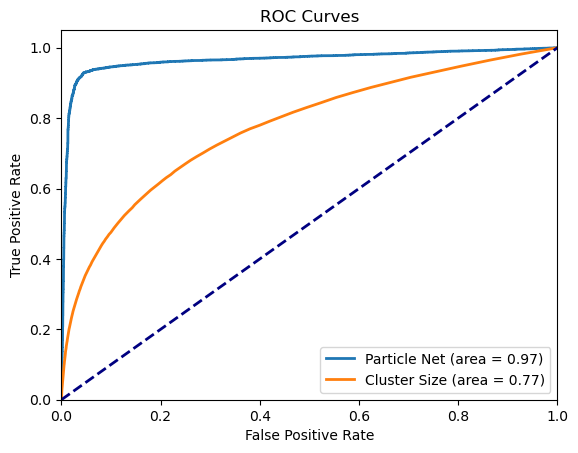

In [30]:
# Evaluate model and plot ROC curve
targets, outputs = evaluate(model, DEVICE, test_loader)
plot_roc_curve(targets, outputs, 'Particle Net')

plot_roc_curve(*get_disc("Size"), 'Cluster Size')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.legend()
plt.show()